<center>
<img src="https://raw.githubusercontent.com/FUlyankin/vk_grand_research/master/images/cover.png">
</center>


# <center> Иканам гранд рисёрч </center>
## <center>  Часть вторая: визуализируем иканам. Кто кого лайкает. </center> 

Проект **Иканам гранд рисёрч** реализуется [Иканам стьюдентс коммьюнити,](https://vk.com/ikanam)
в частности [вот этим парнем по имени Филипп.](https://vk.com/ppilif)  Если вы нашли ошибку или у вас есть предложения, замечания, деньги, слава или женщины, можно ему написать. Весь говнокод, использованный в исследовании распостраняется по лицензии [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) Его можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала. При наличии технической возможности необходимо также указать активную гиперссылку на страницу рисёрча.


In [29]:
import requests        # Пакет для скачки данных из этих ваших интернетов
import pandas as pd    # Пакет для работы с таблицами
import numpy as np     # Пакет для работы с векторами и матрицами

import matplotlib.pyplot as plt  # Пакет для строительства графиков
plt.style.use('ggplot')          # Правильный стиль для графиков
%matplotlib inline
   
# Пакет для красивых циклов. При желании его можно отключить и удалить из всех циклов 
# команду tqdm_notebook.
from tqdm import tqdm_notebook

import pickle   # Пакет для сохранения и подгрузки данных 
path = '../1.Download_vk_data/'  # Папка, куда мы будем всё сохранять 

Подгружаем данные, которые мы до этого заботливо скачали из контакта

In [30]:
# Список юзеров, которые участвуют в исследовании
with open(path + 'ikanam_info_v18-12-17', 'rb') as f:
    names_ids = pickle.load(f)

# Делаем из словаря лист из id 
users = list(names_ids.keys())

# Лайки на стенках за последние два года 
with open(path + 'vk_total_wal_likes_v18-12-17', 'rb') as f:
    wall_likes = pickle.load(f)

# Лайки на фотографиях за последние два года 
with open(path + 'vk_total_photo_likes_v18-12-17', 'rb') as f:
    photo_likes = pickle.load(f)
    
print(len(users), len(wall_likes), len(photo_likes))

# Сразу для удобства заведём вектор с именами 
names = [names_ids[i]['name'] for i in users]

706 621 633


Не забываем о том, что у некоторых юзеров зачищены стены, у некоторых зачищены фотки. 

## 1. Матрица лайков 

Напишем функцию, которая будет по списку id строить лайк-матрицы. По строкам в таких матрицах будут расположены id пользователей. На их пересечении будет стоять число лайков, которое поставил пользователь из строчки i пользователю из столбца j. Ясное дело, никакой симметрии в матрице не будет. На диагонали будет стоять число самолайков. 


**ВНИМАНИЕ! Ниже вас ожидает зашкаливающее количество неоптимальног говнокода. Мне было лениво думать, а получить быстрые результы очень хотелось. Прошу меня простить за это.**

In [31]:
%%time 

def like_matrix_creator(users, wall_likes=wall_likes, photo_likes=photo_likes):
    n = len(users)

    # Вектора с числом постов/ фоток 
    len_ph = np.zeros(n)
    len_wall = np.zeros(n)
    
    for i in range(n):
        # поверяем зачищена ли стенка юзера
        if users[i] in wall_likes.keys():
            len_wall[i] = len(wall_likes[users[i]])
        # проверяем не зачищены ли фоточки
        if users[i] in photo_likes.keys():
            len_ph[i] = len(photo_likes[users[i]])
    
    # Матрицы для абсолютного количества лайков 
    L_photo_abs = np.zeros([n,n])
    L_wall_abs = np.zeros([n,n])
    
    # По строкам расположим тех, кто лайкает 
    # По столбцам тех, кого лайкают 
    for i in range(n):  
        for j in range(n):
            if len_wall[j] > 0:
                a = int(sum([users[i] in v for k,v in wall_likes[users[j]].items()]))
                L_wall_abs[i,j] = a 
    
        for l in range(n):
            if len_ph[l] > 0:
                b = int(sum([users[i] in v for k,v in photo_likes[users[l]].items()]))
                L_photo_abs[i,l] = b    
                    
                    # Добавляем 10**(-10), чтобы потом избежать деления на ноль 
    return L_wall_abs, L_photo_abs, len_wall + 10**(-10), len_ph + 10**(-10)

# Ниже с помощью этой функции мы будем исследовать эконом по курсам, а не весь сразу. 
L_wall_abs, L_photo_abs, len_wall, len_ph = like_matrix_creator(users, wall_likes=wall_likes, photo_likes=photo_likes)

# Общее число лайков
L_abs = L_wall_abs + L_photo_abs 

# Нормировка лайков на количество сделанных постов
n = L_wall_abs.shape[0]
L_wall = L_wall_abs/np.array([list(len_wall)]*n)
L_photo = L_photo_abs/np.array([list(len_ph)]*n)
L = L_abs/np.array([list(len_wall + len_ph)]*n)

CPU times: user 13.7 s, sys: 72.7 ms, total: 13.8 s
Wall time: 13.8 s


Сохраним все эти матрицы, чтобы потом делать в R-shiny красивые визуализации. 

In [5]:
np.save('L_abs', L_abs)
np.save('L', L)
np.save('L_wall', L_wall)
np.save('L_wall_abs', L_wall_abs)
np.save('L_photo', L_photo)
np.save('L_photo_abs', L_photo_abs)

In [31]:
un = pd.DataFrame([users,names])
un.to_csv('uid_names.csv', sep='\t',index=False, header=False)

Посмотрим на наши матрицы. 

In [32]:
L_abs

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    2., ...,    0.,    2.,    0.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    1.,    0.],
       [   0.,    0.,    0., ...,    0.,  177.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,  183.]])

In [33]:
L

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.16666667, ...,  0.        ,
         0.01025641,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00512821,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.90769231,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.44743276]])

Отлично! Пришло время составить несколько лайк-топов. 

## 2. Лайк-топы 

Напишем функцию для визуализации всех наших топов. 

In [32]:
from collections import defaultdict
import itertools    

def top_freq_plot(top, title, names_ids = names_ids, k=30):

    # Сортируем словарик по частотам
    sorted_word_count = sorted(top, key=lambda w: w[1], reverse=True)     
    
    # Делаем срез и по этому срезу строим картиночку 
    example_list = sorted_word_count[:k]
    name = []
    frequency = []
    for i in range(len(example_list)):
        name.append(example_list[i][0])
        frequency.append(example_list[i][1])

    indices = np.arange(len(example_list))
    
    plt.figure(figsize=(22,8))
    plt.bar(indices, frequency)
    plt.xticks(indices, name, rotation='vertical',fontsize=16)
    plt.tight_layout()
    plt.title(title, fontsize = 30)
    pass

### 2.1 Рейтинг самолайков 

Для начала выясним кто на еканаме самый отпетый самолайкер. 

In [33]:
# Составляем список из самолайков
def top_like_yourself(users, L, names_ids = names_ids):
    like_your_self = [ ]
    for i in range(len(users)):
        like_your_self.append((names_ids[users[i]]['name'],L[i,i]))
    return like_your_self

lys = top_like_yourself(users, L, names_ids = names_ids)
lys_abs = top_like_yourself(users, L_abs, names_ids = names_ids) 

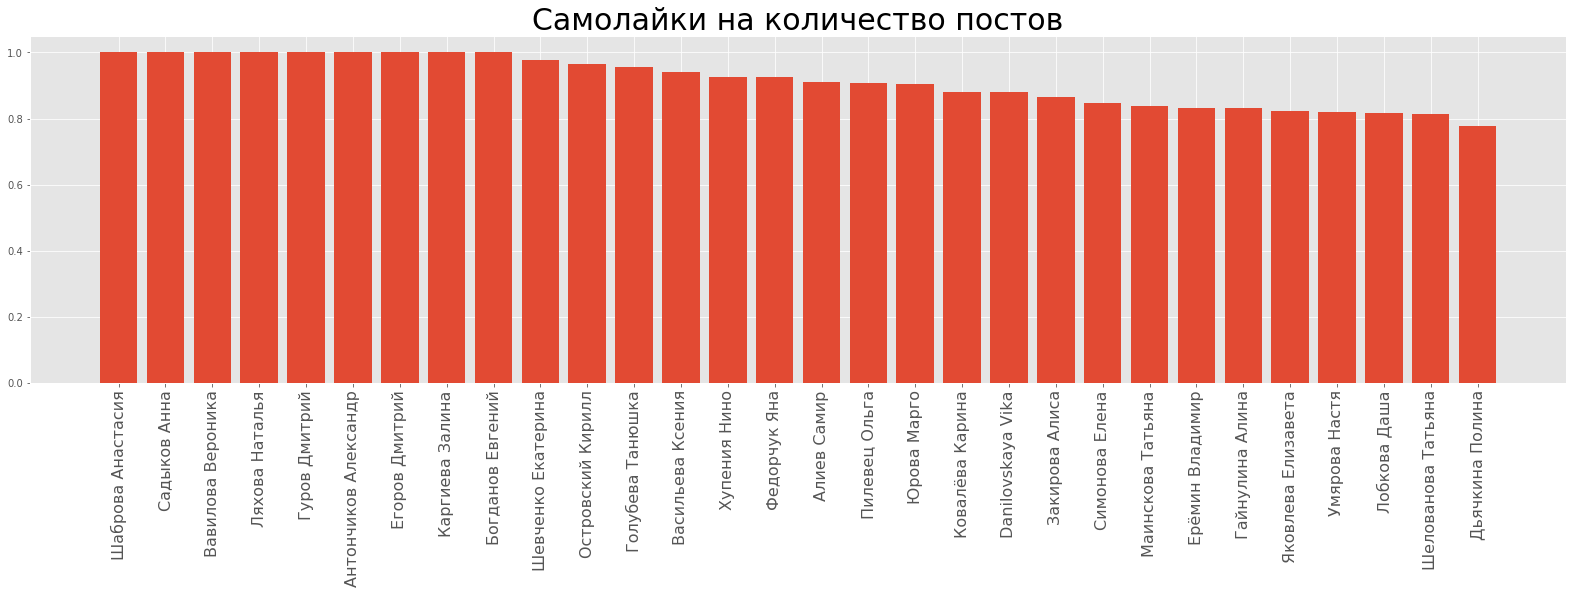

In [34]:
top_freq_plot(lys,'Самолайки на количество постов')

Гуров Дмитрий:  два поста, два самолайка. Высокий коэффициент. 

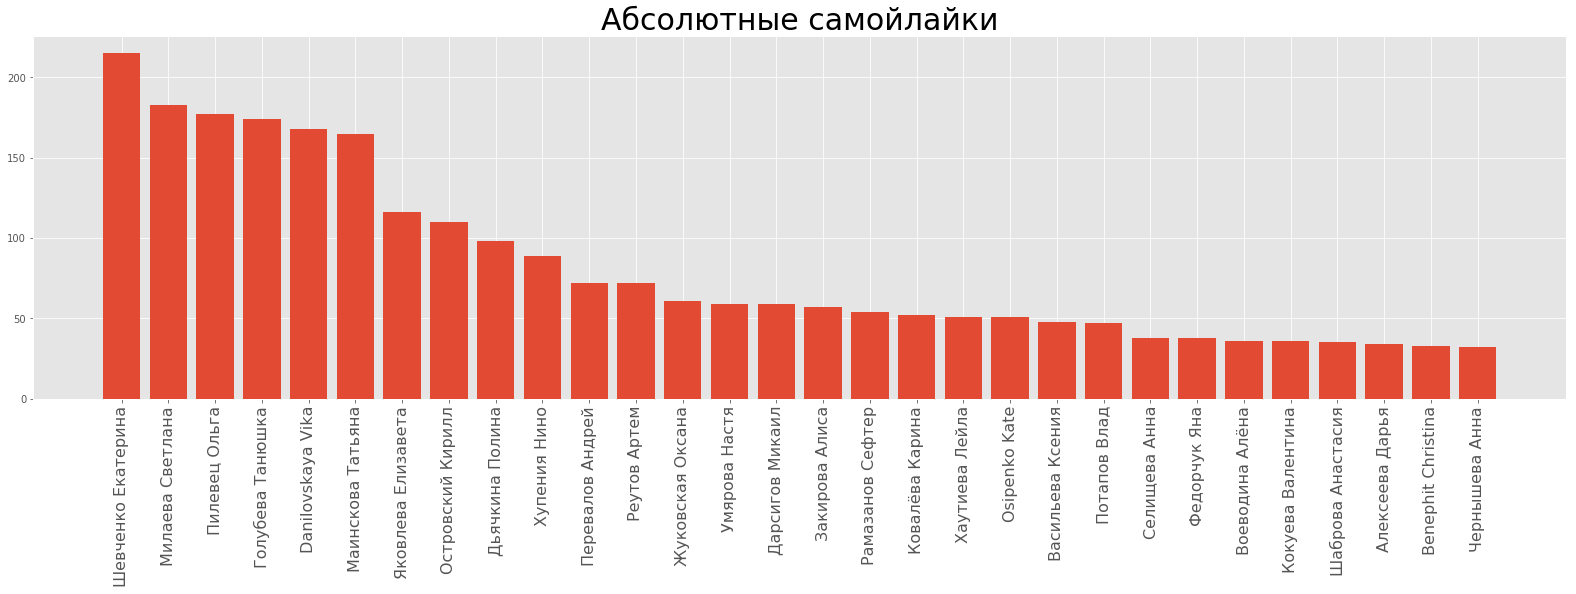

In [35]:
top_freq_plot(lys_abs,'Абсолютные самойлайки')

## 2.2 Самые лайкающие люди на иканаме

Бывают люди, которые ставят очень много лайков всем подряд. Попробуем выцепить самого активного лайкателя. Для этого просуммируем все значения в матрице по столбцам. 

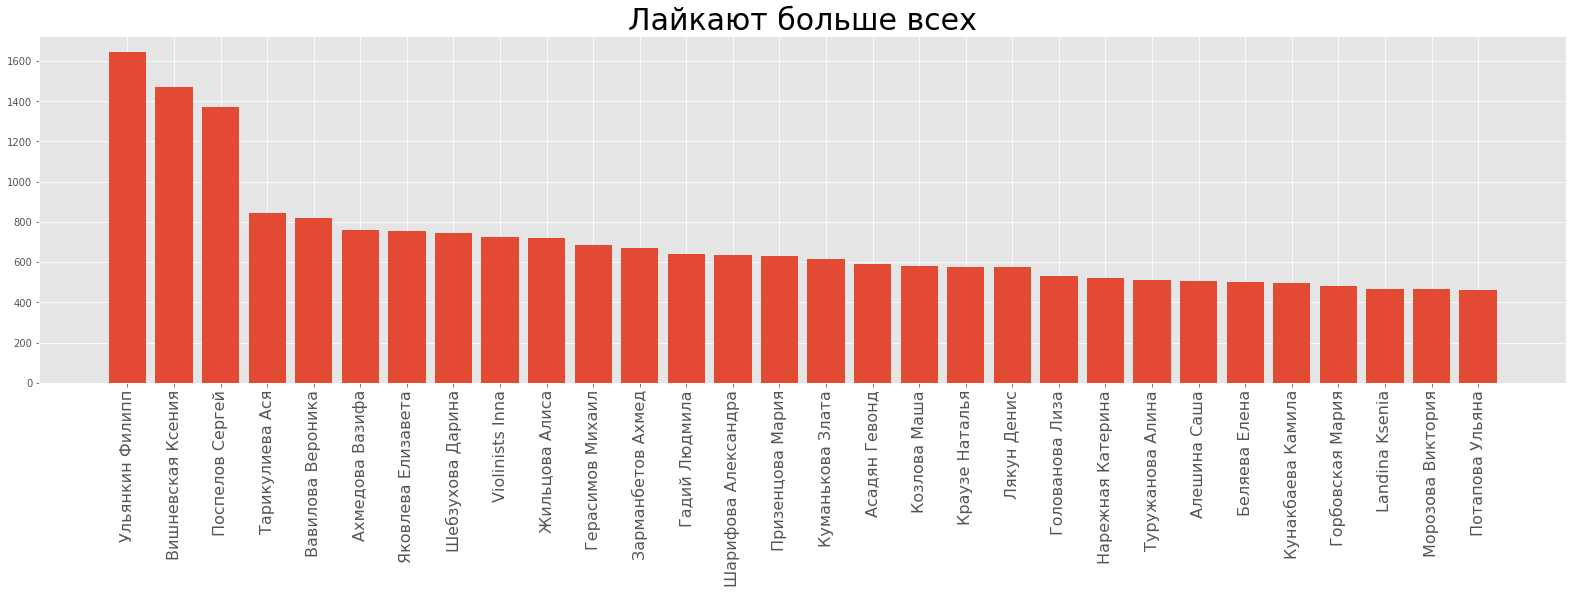

In [36]:
def top_liker(users, L, names_ids = names_ids):
    like_total = [ ]
    for i in range(len(users)):
        like_total.append((names_ids[users[i]]['name'], sum(L[i,:])))
    return like_total

lt_abs = top_liker(users, L_abs, names_ids = names_ids)
top_freq_plot(lt_abs,'Лайкают больше всех')

**Вывод:** Ульянкин Филипп - самая главная социоблядь. 

## 2.3 Самые лайкаемые люди на иканаме

Составим рейтинг самых лайкаемых людей 

In [37]:
def top_like_total(users, L, names_ids = names_ids):
    like_total = [ ]
    for i in range(len(users)):
        like_total.append((names_ids[users[i]]['name'], sum(L[:,i])))
    return like_total

lt_wall  = top_like_total(users, L_wall, names_ids = names_ids)
lt_abs_wall = top_like_total(users, L_wall_abs, names_ids = names_ids) 

lt_photo  = top_like_total(users, L_photo, names_ids = names_ids)
lt_abs_photo = top_like_total(users, L_photo_abs, names_ids = names_ids) 

lt  = top_like_total(users, L, names_ids = names_ids)
lt_abs = top_like_total(users, L_abs, names_ids = names_ids) 

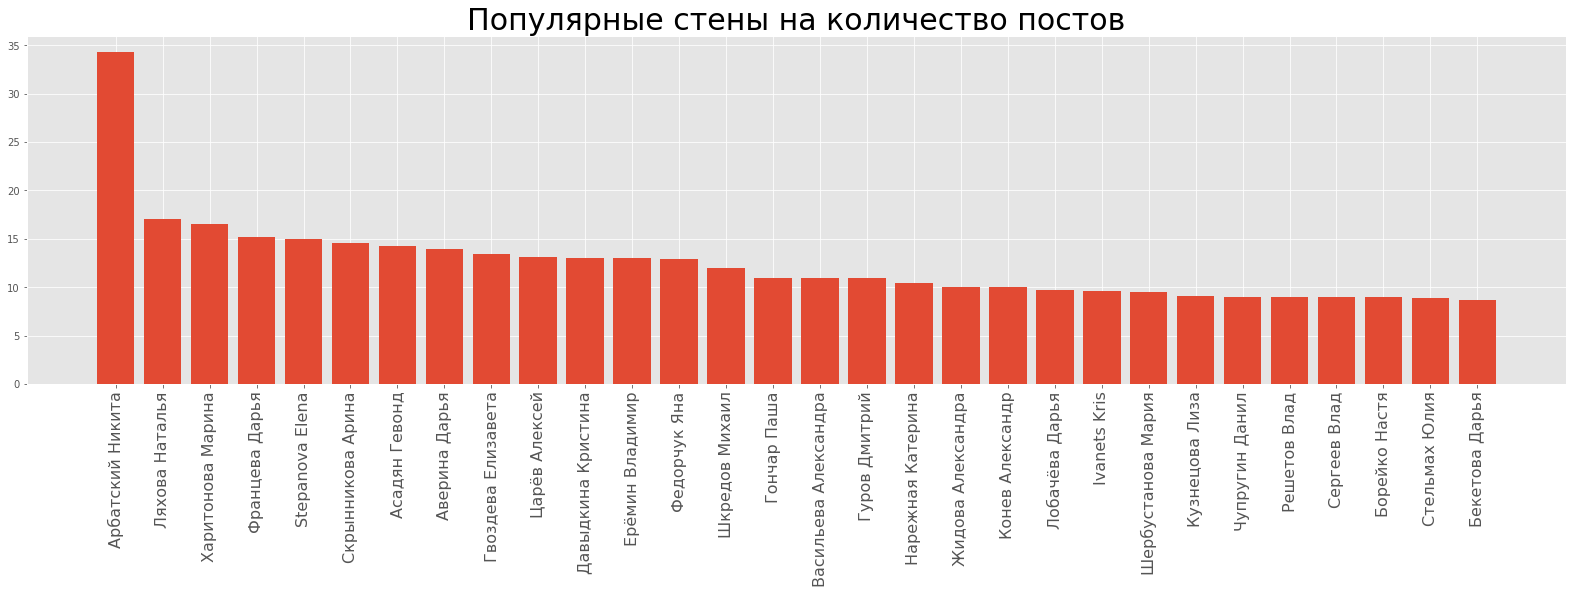

In [38]:
top_freq_plot(lt_wall,'Популярные стены на количество постов')

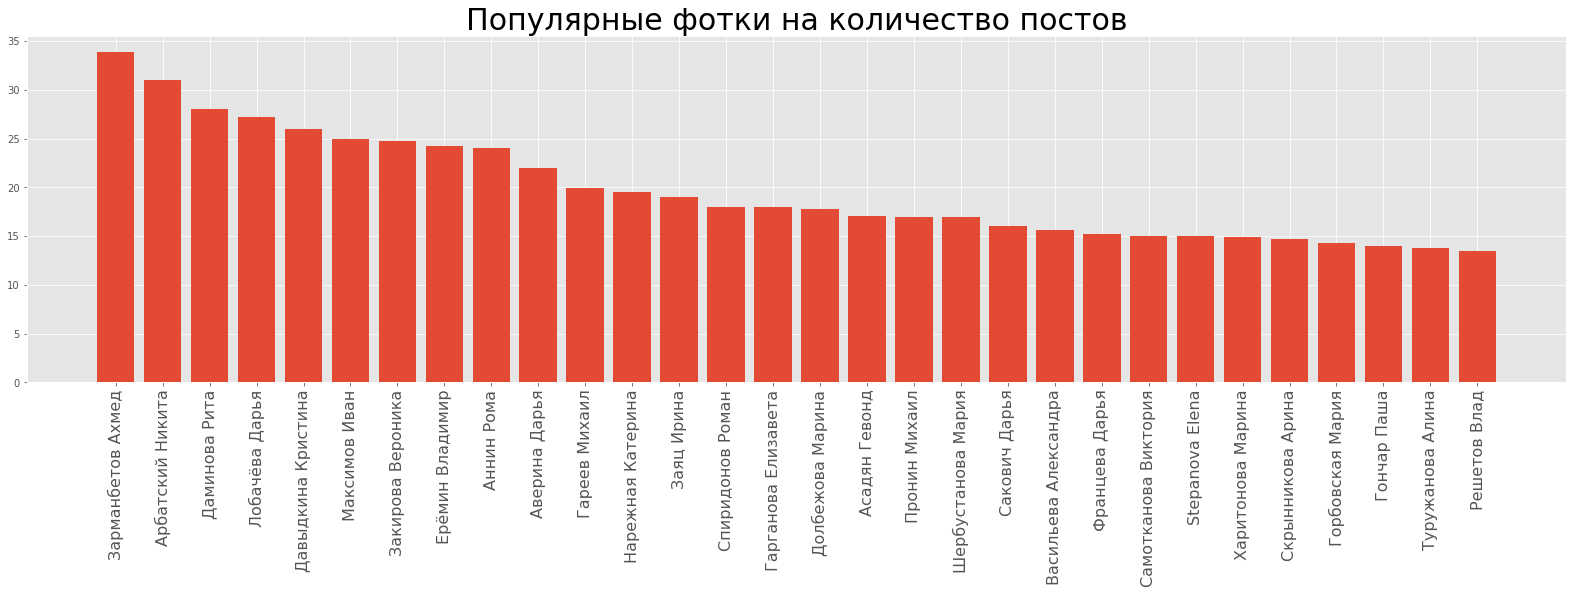

In [39]:
top_freq_plot(lt_photo,'Популярные фотки на количество постов')

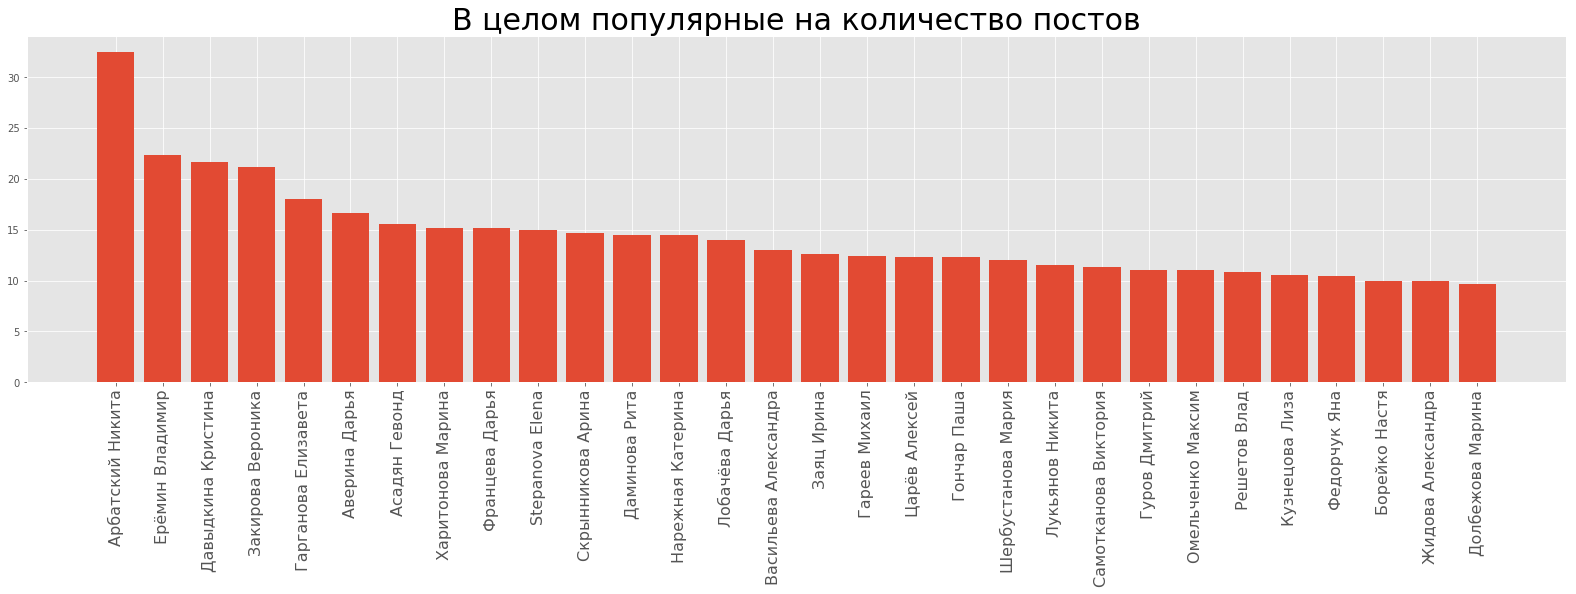

In [40]:
top_freq_plot(lt,'В целом популярные на количество постов')

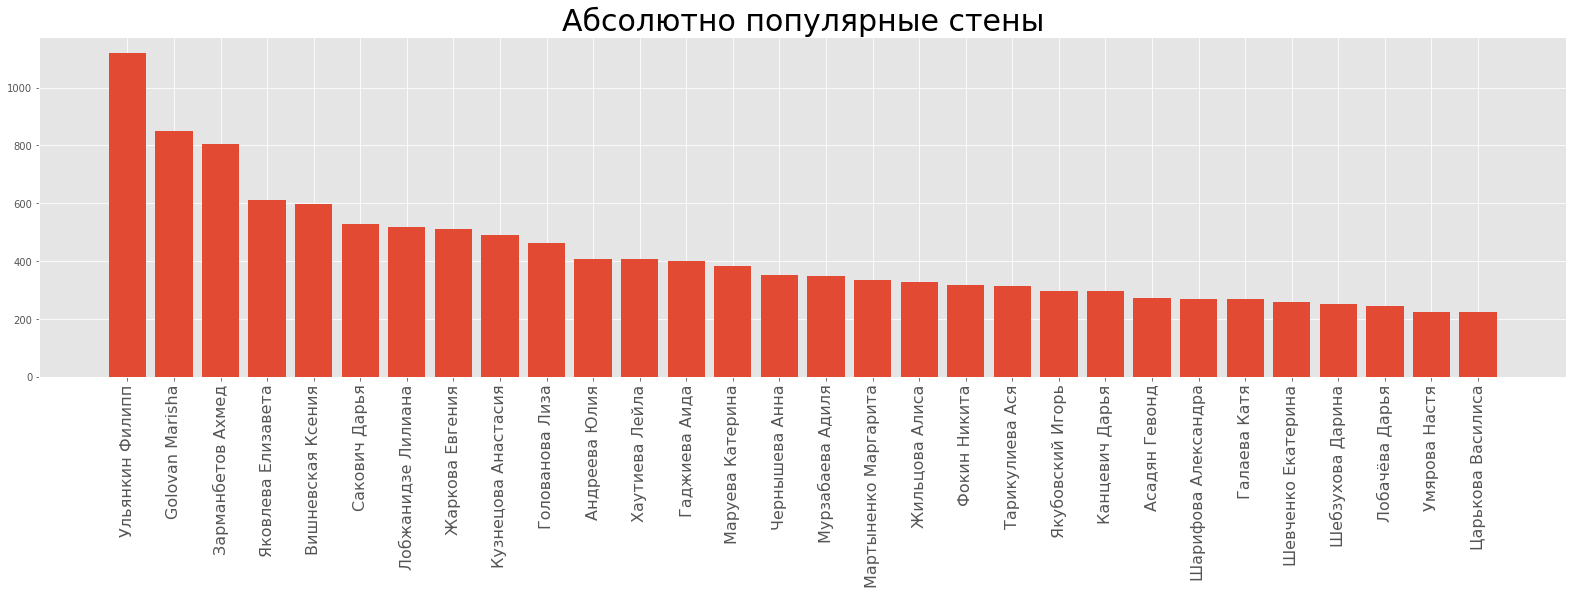

In [41]:
top_freq_plot(lt_abs_wall,'Абсолютно популярные стены')

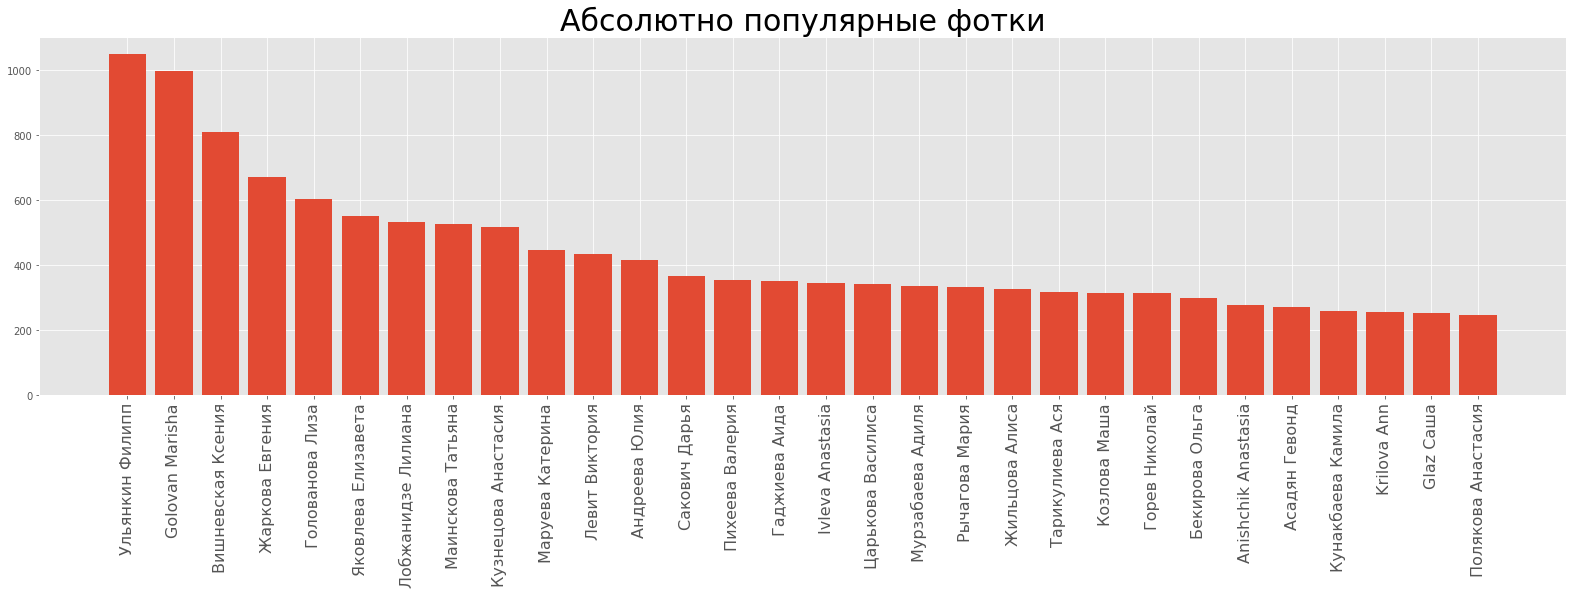

In [42]:
top_freq_plot(lt_abs_photo,'Абсолютно популярные фотки')

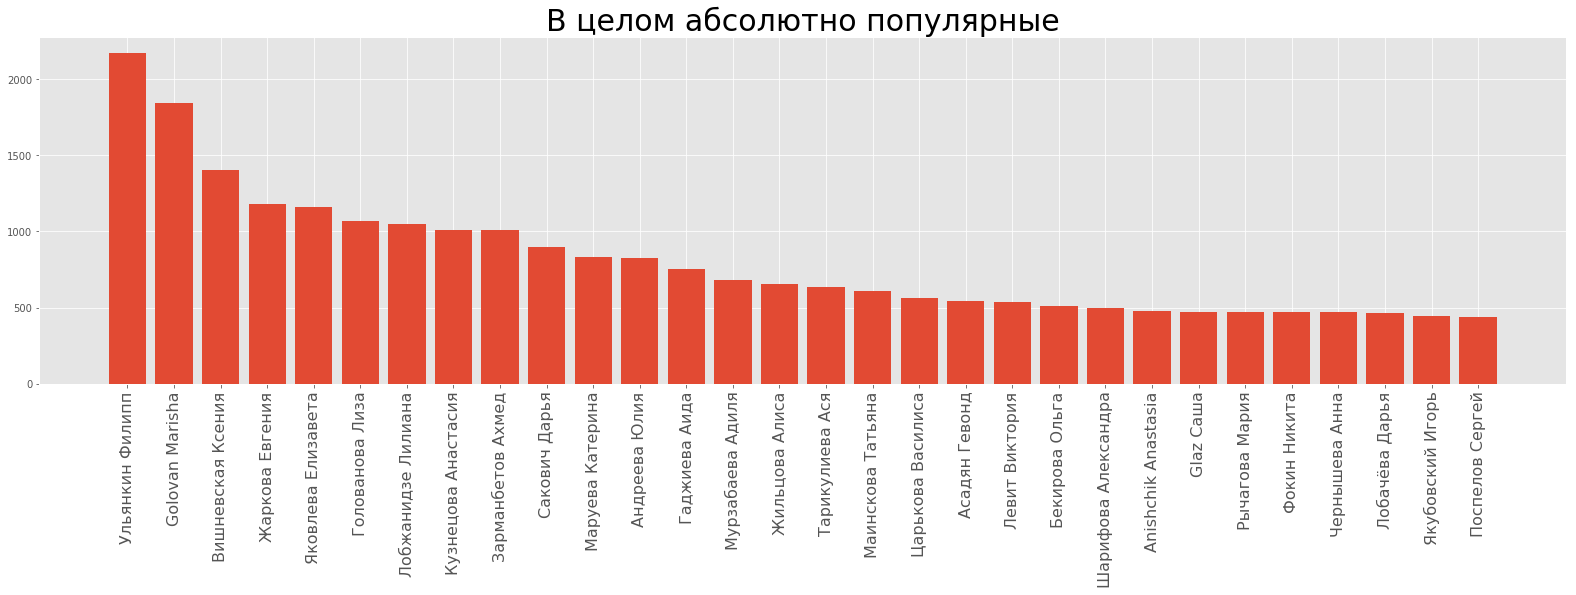

In [43]:
top_freq_plot(lt_abs,'В целом абсолютно популярные')

**Вывод:** Ульянкин Филипп на самом деле хайпожор, который гребёт лайки за счёт количества постов, а не качества. 

## 2.4 Визуализация матрицы лайков 

Можно визуализировать матрицу лайков и увидеть кто кому сколько лайков ставит. Займёмся этим! 

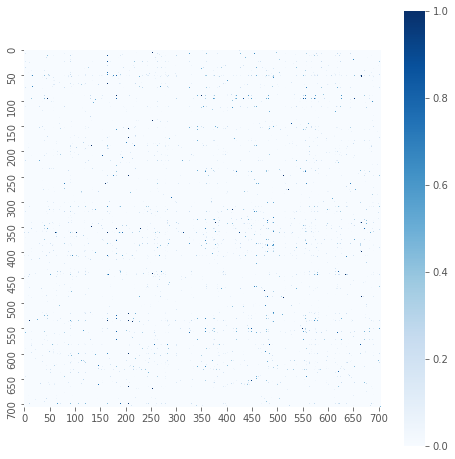

In [44]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(L, xticklabels=50, yticklabels=50, cmap="Blues", square=True)

Как видно, матрица лайков получается довольно разряженой. Попробуем немного увеличить её и вытащим 20 рандомных людей. Не забываем, что человек из строки i поставил столько то лайков человеку из столбца j.

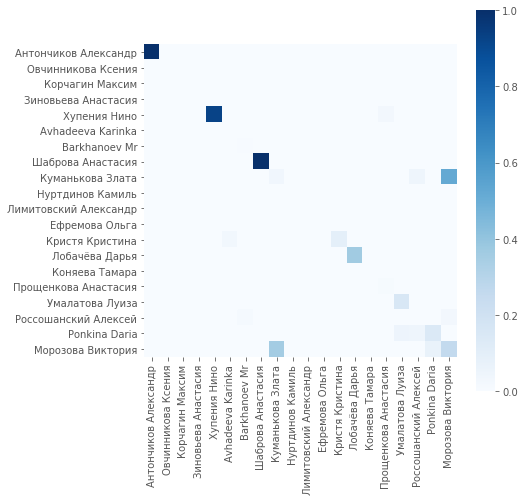

In [45]:
import random 
n_people = 20

index = np.array(random.sample(range(L.shape[0]),n_people))
nmes = [names_ids[us]['name'] for us in np.array(users)[index]]
L_sub = L[index,:][:,index]

plt.figure(figsize=(7,7))
sns.heatmap(L_sub, square=True, xticklabels = nmes, yticklabels=nmes, cmap="Blues")

Теперь сделаем точно такую же матрицу из лайков, но для конкретных людей. 

## 2.5 Индивидуальные лайки 

Пришло время составить индивидуальную статистику по лайкам для каждого человека. Первая функция будет составлять топ тех, кто лайкнул человека. Вторая функция топ тех, кого лайкал человек. При этом эти функции будут работать либо по id либо по имени фамилии. Это связано с тем, что в выборке попадаются люди с одинаковыми именами и фамилиями. 

In [46]:
def like_me(L, name, names_ids = names_ids, users = users, k=20):
    names = [names_ids[i]['name'] for i in users]

    if isinstance(name, str):
        i = names.index(name)
    else:
        i = users.index(name)
        name = names_ids[name]

    li = L[i,:]  # лайкаю я
    lj = L[:,i]  # лайкают меня
    
    # 1. График с теми, кого лайкает человек
    a = zip(names,li,range(len(names)))
    # Сортируем и делаем срез для картиночки
    sorted_word_count1 = sorted(a, key=lambda w: w[1], reverse=True)
    example_list1 = sorted_word_count1[:k]
    nname1 = []
    frequency1 = []
    ind1 = [ ]
    
    for i in range(len(example_list1)):
        nname1.append(example_list1[i][0])
        frequency1.append(example_list1[i][1])
        ind1.append(example_list1[i][2])
        
    indices1 = np.arange(len(example_list1))
    
    plt.figure(figsize=(22,7))
    plt.bar(indices1, frequency1)
    plt.xticks(indices1, nname1, rotation='vertical',fontsize=16)
    plt.tight_layout()
    plt.title(name + ' ставит лайки', fontsize = 30)
    #########################################
      
    # 2. График с теми, кто лайкает человека
    a = zip(names,lj,range(len(names)))
    # Сортируем и делаем срез для картиночки
    sorted_word_count2 = sorted(a, key=lambda w: w[1], reverse=True)
    example_list2 = sorted_word_count2[:k]
    nname2 = []
    frequency2 = []
    ind2 = [ ]
    
    for i in range(len(example_list2)):
        nname2.append(example_list2[i][0])
        frequency2.append(example_list2[i][1])
        ind2.append(example_list2[i][2])
    
    indices2 = np.arange(len(example_list2))
    
    plt.figure(figsize=(22,7))
    plt.bar(indices2, frequency2)
    plt.xticks(indices2, nname2, rotation='vertical',fontsize=16)
    plt.tight_layout()
    plt.title(name + ' получает лайки', fontsize = 30)
    
    # 3. Матрица обмена лайками между людьми выше
    #ind = np.array(list(set(ind1+ind2)))
    #nname = np.array(names)[ind]
    
    #plt.figure(figsize=(8,8))
    #L_sub = L[ind,:][:,ind]
    #sns.heatmap(L_sub, square=True, cmap="Blues", cbar=False, xticklabels = nname, yticklabels=nname)
    pass

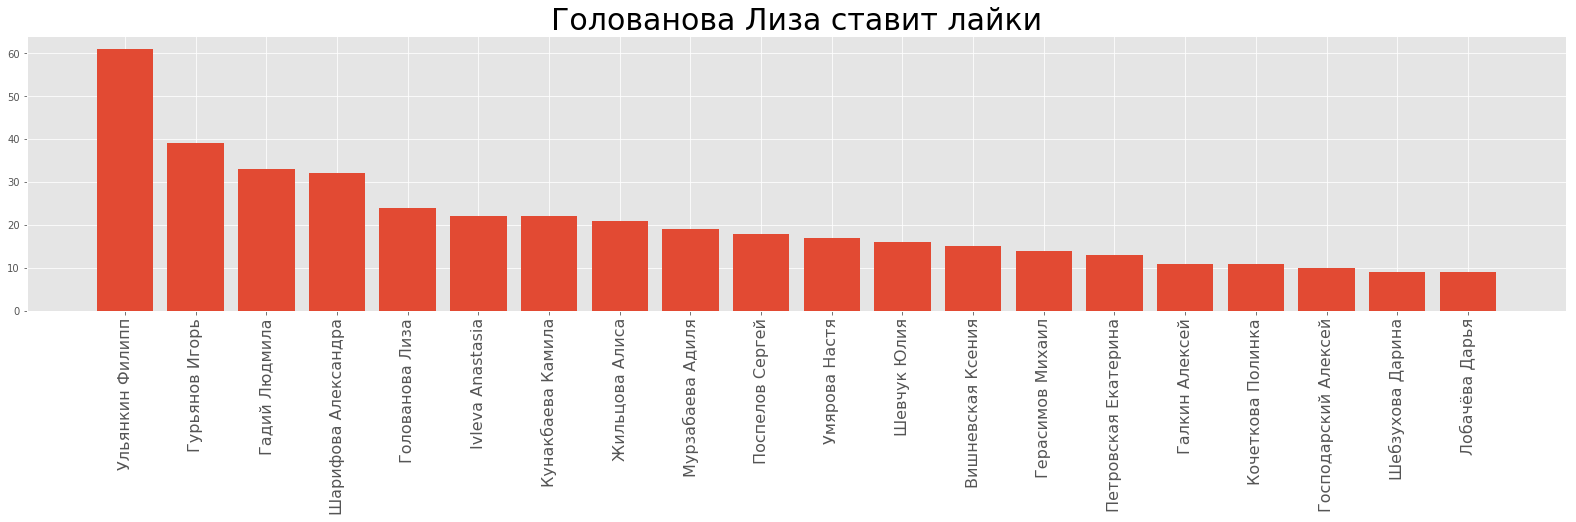

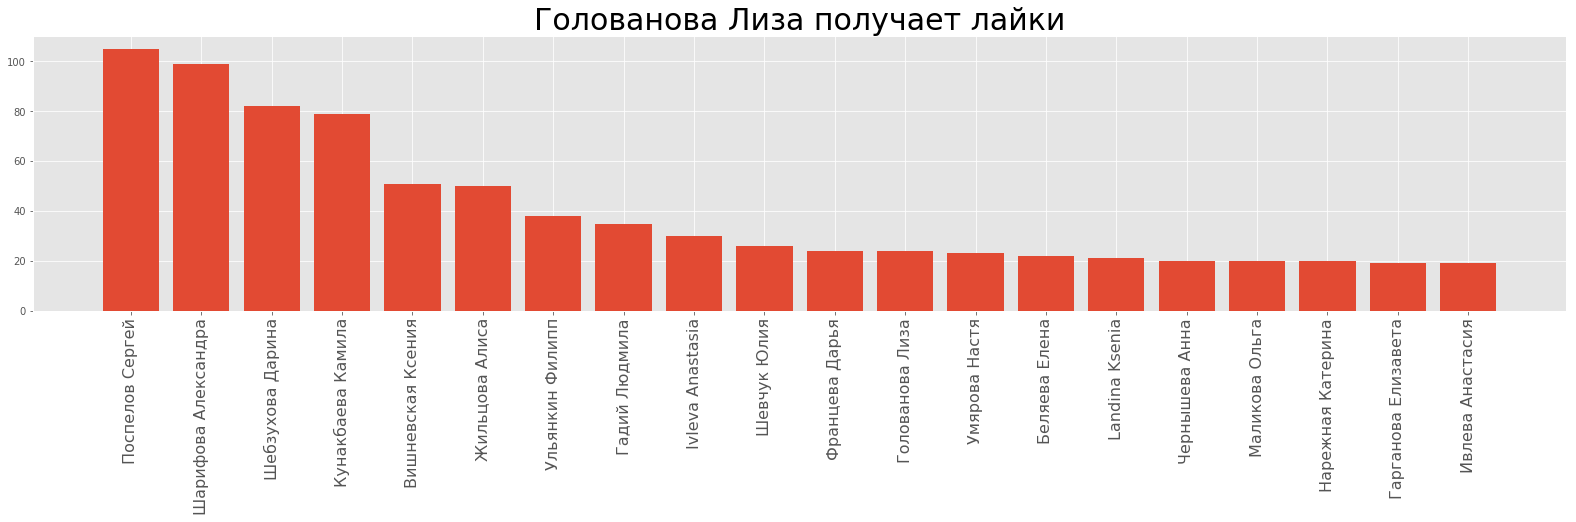

In [52]:
like_me(L_abs, 'Голованова Лиза')

## 2.6 Кто чаще всего попадает в топы по лайкам 

Итак, мы выяснили, что у каждого человека есть свой лайковый топ. Интересно было бы узнать кто попадает в топ к другим людям чаще всего. 

In [134]:
# Функция возвращает тех, кого лайкает юзер
def my_likers(L, name, names_ids = names_ids, k=20):
    names = [names_ids[i]['name'] for i in users]

    if isinstance(name, str):
        i = names.index(name)
    else:
        i = users.index(name)
        name = names_ids[name]

    li = L[i,:]  # Я ставлю лайки 
    a = zip(names,li,range(len(names)))
    # Сортируем и делаем срез
    sorted_word_count1 = sorted(a, key=lambda w: w[1], reverse=True)
    return sorted_word_count1[:k]

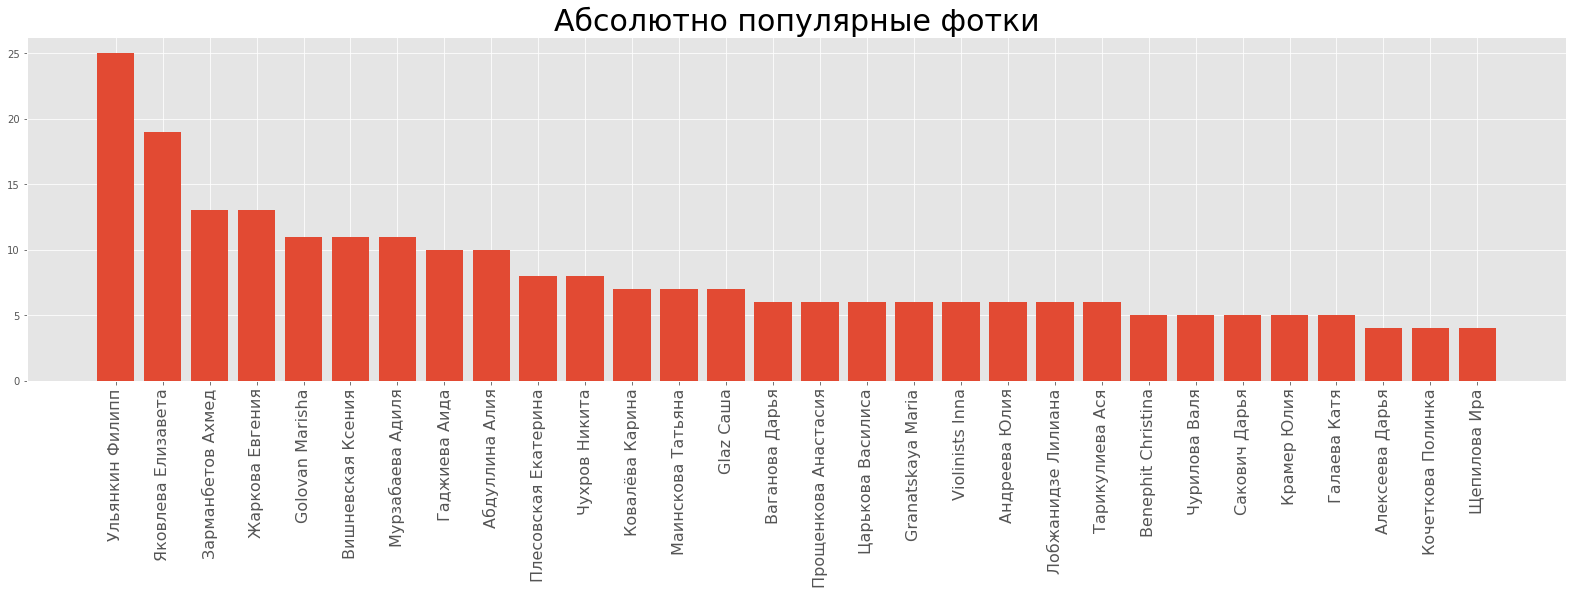

In [137]:
top_user_dct = {names_ids[us]['name'] : [ ] for us in users}

for user in users: 
    g = my_likers(L_abs, user, k=1)  # Вытащили топ людей, которых лайкает юзер 
    for item in g:               # Прошлись по топу 
        if item[1] > 0:
            # Добавили каждому из топа user в достижения 
            top_user_dct[names_ids[users[item[2]]]['name']].append(names_ids[user]['name'])  

top_user_cnt = [ ]
for k,v in top_user_dct.items():
     top_user_cnt.append((k,len(v)))

top_freq_plot(top_user_cnt, 'Абсолютно популярные фотки')

In [143]:
print(top_user_dct['Ульянкин Филипп'], '\n')
print(top_user_dct['Яковлева Елизавета'], '\n')
print(top_user_dct['Зарманбетов Ахмед'], '\n')

['Потапова Мария', 'Кочеткова Полинка', 'Фокин Никита', 'Залевская Мария', 'Скворцов Максим', 'Кульчицкий Юрий', 'Ратных Мария', 'Зарманбетов Ахмед', 'Арутюнян Баграт', 'Шелованова Татьяна', 'Давыдкина Кристина', 'Поздеев Дмитрий', 'Evseev Alexey', 'Конев Александр', 'Умалатова Луиза', 'Лупарев Евгений', 'Веретенников Степан', 'Матросова Ксения', 'Семенова Алёна', 'Беспалов Ярослав', 'Кинякина Ксения', 'Асадян Гевонд', 'Морозова Виолетта', 'Беленко Вера', 'Голованова Лиза'] 

['Гусевская Алина', 'Васильева Александра', 'Стельмах Юлия', 'Леки Леки', 'Антончиков Александр', 'Брик Надя', 'Селиванова Виктория', 'Вафоева Фируза', 'Рычагова Мария', 'Козлова Маша', 'Бекирова Ольга', 'Шлапацкая Екатерина', 'Яковлева Елизавета', 'Свистельникова Татьяна', 'Горбик Вероника', 'Колотовкина Анастасия', 'Лепихина Анна', 'Лобкова Даша', 'Лякун Денис'] 

['Харитонова Марина', 'Щепилова Ира', 'Гареев Михаил', 'Закиров Денис', 'Спиридонов Роман', 'Мидюкин Максим', 'Скиба Виталий', 'Андреев Даниил', 'Коро

## 2.7 Мэтчинги 

Я в топе у неё, а она в топе у меня. Найдём подобные любовные парочки... 

In [144]:
# Получаем словарики. Юзера, находящегося в ключе, лайкают юзеры из значений. 

def match_find(L, n_match): # количество людей из топа, на которые надо смотреть
    
    love = { }
    for user in users:
        res = my_likers(L, user)[:n_match]
        love[user] = [users[r[2]] for r in res]

    matching = [ ]
    for key in love.keys():
        ans = love[key]
        for an in ans:
            if (key in love[an])&(key != an):  # ключ в топе у ответа и нет самолайков
                an = tuple(sorted([key,an]))
                matching.append(an)

    # Каждая пара окажется в списке по два раза. Убираем дубликаты
    matching = list(set(matching))
    return matching

Визуализируем мэтчинги! Чтобы визуализация оказалась красивой, подгрузим аватарки юзеров, которые мы бережно обработали в другом куске кода. 

In [145]:
# Подгружаем фоточки 
with open(path + 'vk_user_photo_dict', 'rb') as f:
    user_photo_dct = pickle.load(f)

import urllib  # Пакеты для загрузки любви 
import cv2     # Пакет для работы с фоточками 

# Подгружаем любовь
def url_to_image(url):
    resp = urllib.request.urlopen(url)                        # Открываем фото
    image = np.asarray(bytearray(resp.read()), dtype="uint8") # Распаковываем его в матрицу
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # Конвертируем в формат для нашего пакета   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)            # Выбираем нужную цветовую схему 
    return image

love_img = url_to_image('http://www.mobilmusic.ru/mfile/1d/50/f0/1416683.jpg')

# Функция для отрисовки любви 
def visualize(users):
    plt.figure(figsize=(6,5))
    us1 = user_photo_dct[users[0]]
    us2 = user_photo_dct[users[1]]

    # Рисуем первого юзера
    plt.subplot(1,3,1)
    plt.title(names_ids[users[0]]['name'])
    plt.imshow(us1)
    plt.xticks([]), plt.yticks([])
    
    # Рисуем любовь 
    plt.subplot(1,3,2)
    plt.imshow(love_img)
    plt.xticks([]), plt.yticks([])
    
    # Рисуем второго юзера
    plt.subplot(1,3,3)
    plt.title(names_ids[users[1]]['name'])
    plt.imshow(us2)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [146]:
# Находим все мэтчинги топ-1 
match_1 = match_find(L_abs, 1)

# Находим все мэтчинги топ-2 
match_2 = match_find(L_abs, 2)
# Очищаем топ-2 от топ-2 
match_2 = list(set(match_2) - set(match_1))
# Это была алгебра множеств, детка! 

Вузуализируем топ-1 

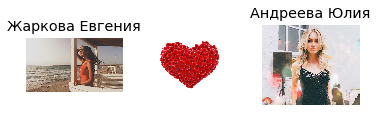

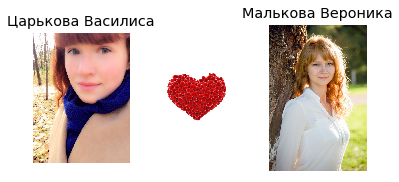

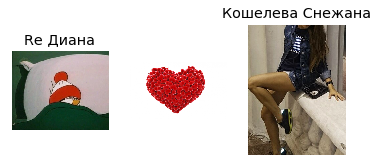

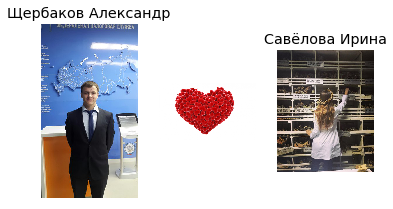

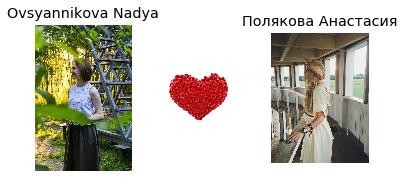

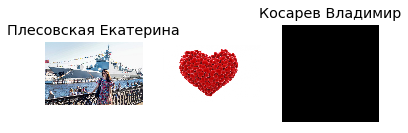

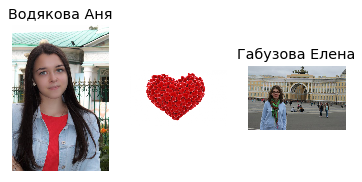

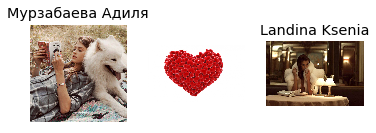

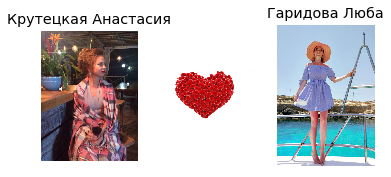

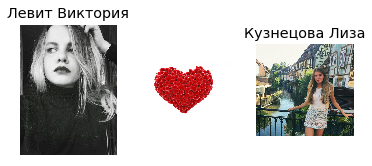

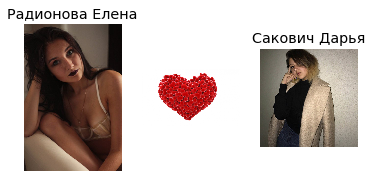

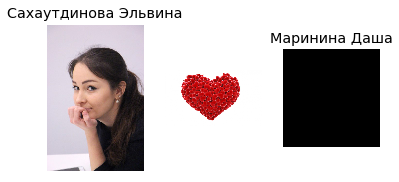

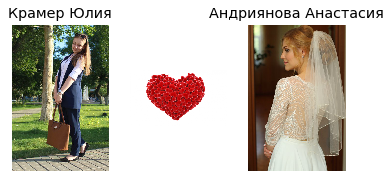

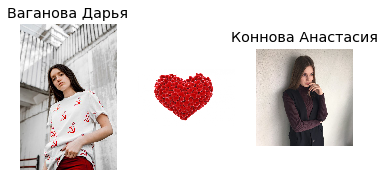

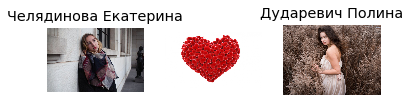

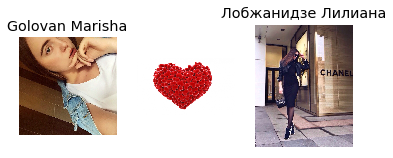

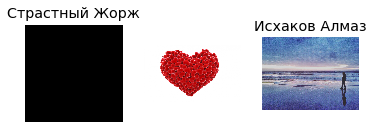

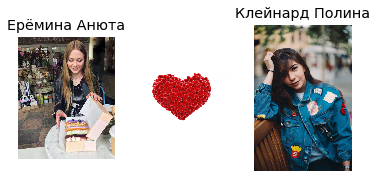

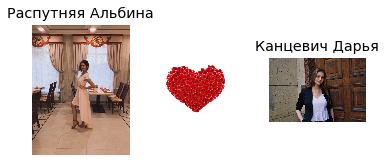

In [147]:
for mtch in match_1:
    visualize(mtch)

Визуализируем топ-2 

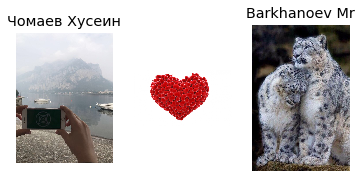

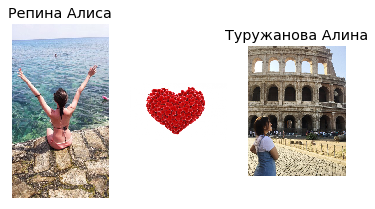

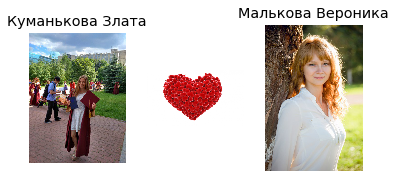

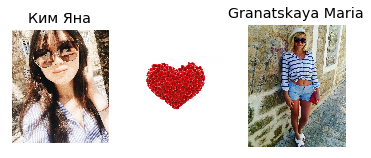

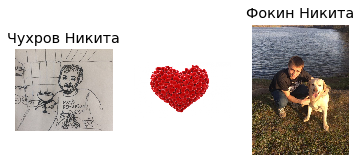

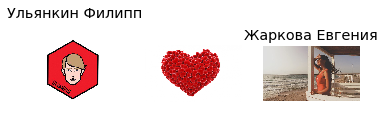

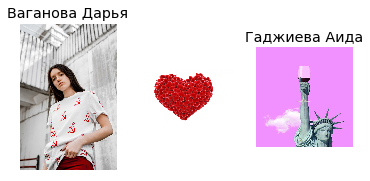

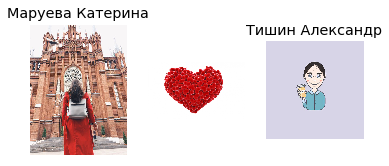

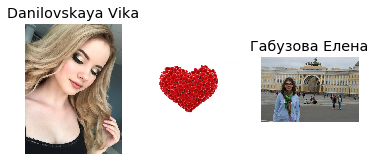

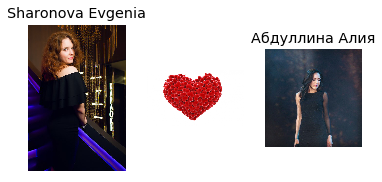

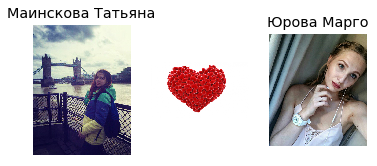

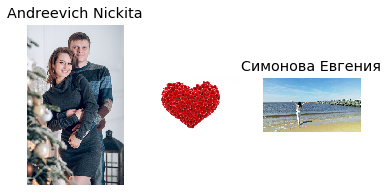

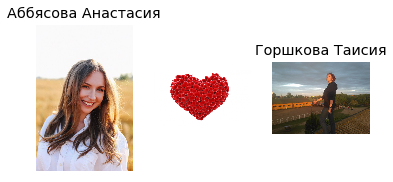

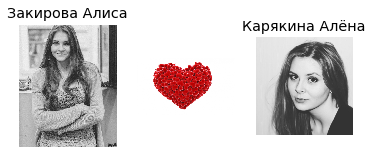

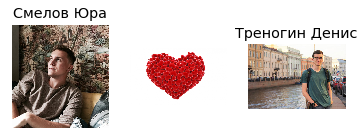

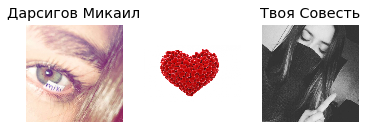

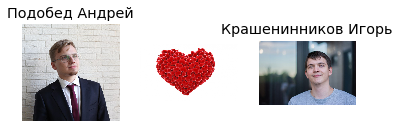

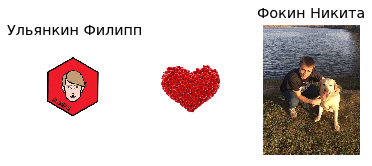

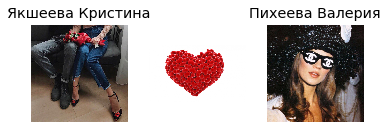

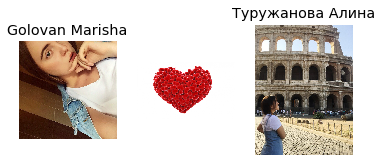

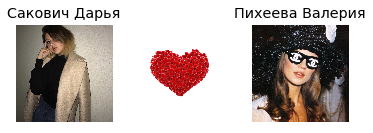

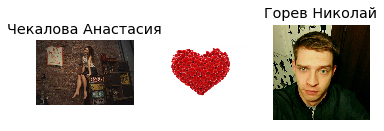

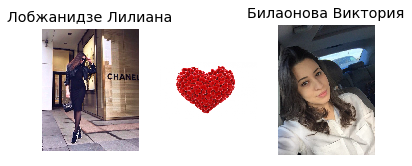

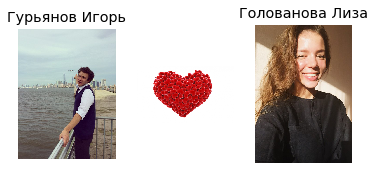

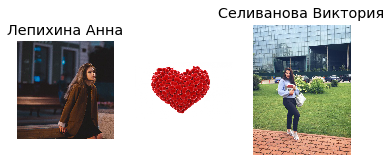

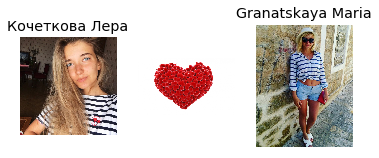

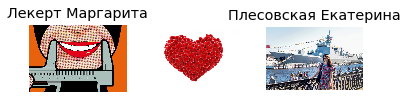

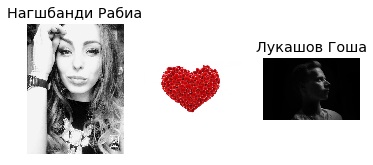

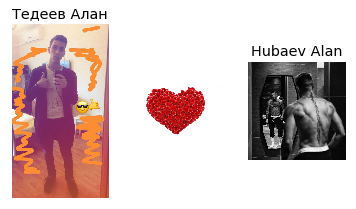

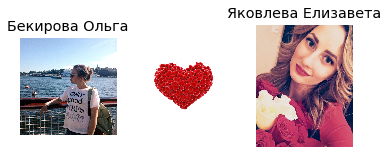

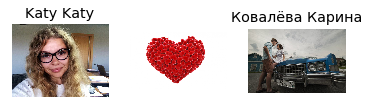

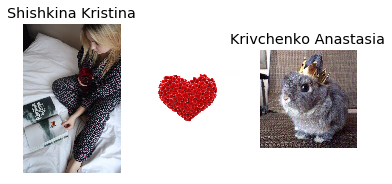

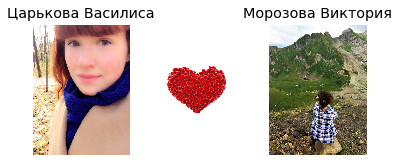

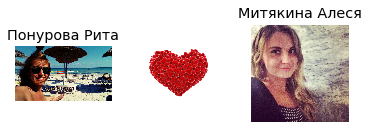

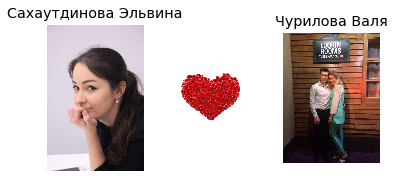

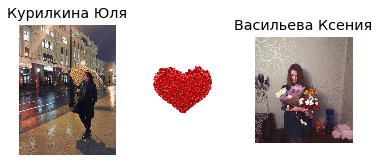

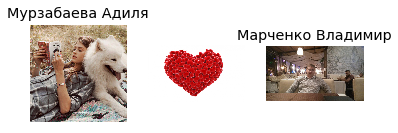

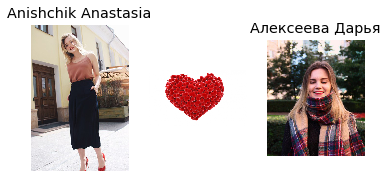

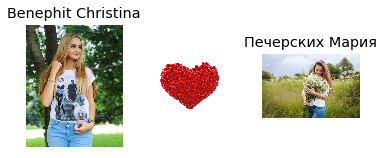

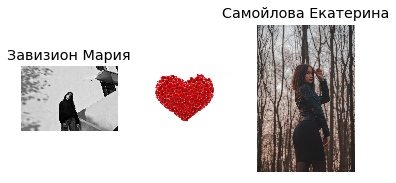

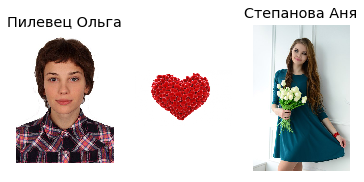

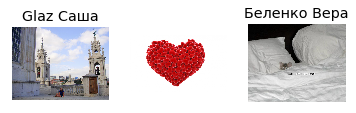

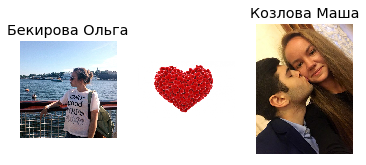

In [148]:
for mtch in match_2:
    visualize(mtch)

Отлично! Первая часть наших лайк-визуализаций готова. Перейдём к более серьёзной части. К графу иканама и к графу лайков иканама. 

<img align="center" src="https://raw.githubusercontent.com/FUlyankin/vk_grand_research/master/images/cats.jpg" height="1200" width="1200"> 